In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

from tqdm import tqdm

import sys
import spikeinterface as si
import matplotlib.pyplot as plt
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import probeinterface

from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup
from probeinterface import generate_dummy_probe, generate_linear_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb
from torch.nn.functional import max_pool1d

import torch
import torch.nn as nn
import torch.nn.functional as F

In [32]:
def count_array2_in_range_of_array1(array1, array2, threshold=5):
    sorted_array1 = np.sort(array1)
    
    lefts = array2 - threshold
    rights = array2 + threshold
    
    left_indices = np.searchsorted(sorted_array1, lefts, side='left')
    
    right_indices = np.searchsorted(sorted_array1, rights, side='right')
    
    has_within_range = right_indices > left_indices
    
    count = np.sum(has_within_range)
    
    return count
def label_array1_based_on_array2(array1, array2, threshold=5):
    """
    根据 array2 的值对 array1 进行标记。
    如果 array1 中的某个值在 threshold 范围内存在于 array2 中，则标记为 1，否则为 0。
    
    参数:
    array1 : numpy.ndarray
        要标记的数组。
    array2 : numpy.ndarray
        用于判断的数组。
    threshold : int
        判断范围的阈值。
    
    返回:
    labels : numpy.ndarray
        长度为 len(array1) 的标签数组，值为 0 或 1。
    """
    sorted_array2 = np.sort(array2)
    
    labels = np.zeros(len(array1), dtype=int)
    
    for i, value in enumerate(array1):
        left = value - threshold
        right = value + threshold
        
        left_index = np.searchsorted(sorted_array2, left, side='left')
        right_index = np.searchsorted(sorted_array2, right, side='right')
        
        if right_index > left_index:
            labels[i] = 1
    
    return labels

def extract_windows(data, indices, window_size=61):
    """
    根据给定的时间点索引提取窗口。
    
    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_channels, time)
    indices : numpy.ndarray
        时间点索引数组，用于指定需要提取窗口的中心点
    window_size : int
        窗口长度，默认为61（对应time-30到time+31）
    
    返回:
    windows : numpy.ndarray
        提取的窗口数据，形状为 (len(indices), n_channels, window_size)
    """
    n_channels, time_length = data.shape
    half_window = window_size // 2

    if np.any(indices < half_window) or np.any(indices >= time_length - half_window):
        raise ValueError("Some indices are out of bounds for the given window size.")

    windows = []
    for idx in indices:
        window = data[:, idx - half_window:idx + half_window + 1]
        windows.append(window)

    windows = np.array(windows)
    return windows

def detect_local_maxima_in_window(data, window_size=20, std_multiplier=2):
    """
    在每个滑动窗口范围内检测局部最大值的索引，并确保最大值大于两倍的标准差。

    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_rows, n_columns)。
    window_size : int
        滑动窗口的大小，用于定义局部范围，默认为 20。
    std_multiplier : float
        标准差的倍数，用于筛选局部最大值，默认为 2。

    返回:
    local_maxima_indices : list of numpy.ndarray
        每行局部最大值的索引列表，每个元素是对应行局部最大值的索引数组。
    """
    local_maxima_indices = []

    for row in data:
        maxima_indices = []
        row_std = np.std(row)
        threshold = std_multiplier * row_std

        for start in range(0, len(row), window_size):
            end = min(start + window_size, len(row))
            window = row[start:end]
            
            if len(window) > 0:
                local_max_index = np.argmax(window)
                local_max_value = window[local_max_index]
                
                if local_max_value > threshold:
                    maxima_indices.append(start + local_max_index)  
        
        local_maxima_indices.extend(maxima_indices)
        local_maxima_indices = list(set(local_maxima_indices))  

    return local_maxima_indices

In [79]:
channel_indices = {
        "1": [1, 3, 5, 7, 9, 11],
        "2": [13, 15, 17, 19, 21, 23],
        "3": [24, 25, 26, 27, 28, 29],
        "4": [12, 14, 16, 18, 20, 22],
        "5": [0, 2, 4, 6, 8, 10]
        }
channel_position = {
    0: [650, 0],
    2: [650, 50],
    4: [650, 100],
    6: [600, 100],
    8: [600, 50],
    10: [600, 0],
    1: [0, 0],
    3: [0, 50],
    5: [0, 100],
    7: [50, 100],
    9: [50, 50],
    11: [50, 0],
    13: [150, 200], 
    15: [150, 250],
    17: [150, 300],
    19: [200, 300],
    21: [200, 250],
    23: [200, 200],
    12: [500, 200],
    14: [500, 250],
    16: [500, 300],
    18: [450, 300],
    20: [450, 250],
    22: [450, 200],
    24: [350, 400],
    26: [350, 450],
    28: [350, 500],
    25: [300, 400],
    27: [300, 450],
    29: [300, 500]}

In [34]:
recording_raw = se.read_blackrock(file_path='/media/ubuntu/sda/data/mouse6/ns4/natural_image/mouse6_021322_natural_image001.ns4')
recording_recorded = recording_raw.remove_channels(["98", '31', '32'])
recording_stimulated = recording_raw.channel_slice(['98'])

recording_f = spre.bandpass_filter(recording_recorded, freq_min=300, freq_max=3000)
recording_f = spre.common_reference(recording_f, reference="global", operator="median")

In [35]:
data = recording_f.get_traces().astype("float32")

In [58]:
threshold_result = detect_local_maxima_in_window(data.T)

In [1]:
threshold_result = np.array(threshold_result)
valid_indices = threshold_result[(threshold_result > 30)]
valid_indices = valid_indices[valid_indices < data.shape[1] - 31]

NameError: name 'np' is not defined

In [36]:
import pickle
with open('/home/ubuntu/Documents/jct/project/code/Spike_Sorting/sorting_results/021322/neuron_inf.pkl', 'rb') as f:
    neuron_inf = pickle.load(f)

In [9]:
for i in range(len(neuron_inf)):
    temp = neuron_inf['channel_waveform'].values[i]
    
    zero_cols = [j for j in range(temp.shape[1]) if np.sum(temp[:, j]) == 0]
    
    if zero_cols:
        print(f"Detect zero in neuron {neuron_inf['Neuron'].values[i]}, columns: {zero_cols}")
        
        new_waveform = np.delete(temp, zero_cols, axis=1)
        neuron_inf.at[i, 'channel_waveform'] = new_waveform
        
        channel_id_list = neuron_inf['channel_id'].values[i]  
        new_channel_id = [ch for idx, ch in enumerate(channel_id_list) if idx not in zero_cols]
        neuron_inf.at[i, 'channel_id'] = new_channel_id

In [10]:
for i in range(len(neuron_inf)):
    temp = neuron_inf['channel_waveform'].values[i].T
    channel_id = neuron_inf['channel_id'].values[i]
    waveform = np.zeros((temp.shape[0], 30))

    for j in range(temp.shape[1]):
        waveform[:, channel_id[j]] = temp[:, j]

    neuron_inf['channel_waveform'].values[i] = waveform
    

In [11]:
spike_inf = pd.read_csv('/home/ubuntu/Documents/jct/project/code/Spike_Sorting/sorting_results/021322/spike_inf.csv')

In [46]:
i = 0
win_size = 5
U = neuron_inf['channel_waveform'].values[i].copy()
U_normalize = U/(U**2).sum()**.5


channel_id = neuron_inf['channel_id'].values[i].copy()
threshold_result_temp = []
for j in range(len(channel_id)):
    threshold_result_temp.extend(threshold_result[channel_id[j]])

threshold_result_temp = np.array(list(set(threshold_result_temp)))

threshold_result_temp = threshold_result_temp - 30
valid_indices = threshold_result_temp[(threshold_result_temp > 30)]
valid_indices = valid_indices[valid_indices < data.shape[0] - 31]

sample_data = extract_windows(data.T, valid_indices, window_size=61).transpose(0, 2, 1)


In [ ]:
i = 0
U = neuron_inf['channel_waveform'].values[i].copy()
U_normalize = U/(U**2).sum()**.5


channel_id = neuron_inf['channel_id'].values[i].copy()

threshold_result = np.array(threshold_result)

valid_indices = threshold_result[(threshold_result > 30)]
valid_indices = valid_indices[valid_indices < data.shape[0] - 31]

sample_data = extract_windows(data.T, valid_indices, window_size=61).transpose(0, 2, 1)


In [99]:
U_normalize.shape

(61, 30)

In [98]:
sample_data.shape

(9297383, 61, 30)

In [100]:
scores_raw = np.einsum('ij,nij->in', U_normalize, sample_data)


In [101]:
scores_raw.shape

(61, 9297383)

In [77]:
scores_raw = np.einsum('ij,nij->in', U_normalize, sample_data)
scores_raw = np.mean(scores_raw, axis = 0)

scores = np.einsum('ij,nij->in', U_normalize, sample_data)** 2
scores = scores.max(axis= 0)


In [76]:
scores_raw.shape

(9297383,)

In [96]:
win_size = 5
scores = torch.tensor(scores)

pooled = max_pool1d(
    scores.unsqueeze(0).unsqueeze(0),
    kernel_size=win_size,
    stride=1,
    padding=win_size//2
).squeeze()

is_peak = (scores == pooled) & (torch.abs(pooled) > 0) 
spike_train = np.where(is_peak.numpy())[0]

spike_inf_temp = spike_inf[spike_inf['cluster'] == int(neuron_inf['cluster'].values[i])]
print(len(spike_train))
count_array2_in_range_of_array1(spike_train, spike_inf_temp['time'].values, threshold=5) / len(spike_inf_temp['time'])

1747593


0.2147962475802849

In [97]:
count_array2_in_range_of_array1(threshold_result, spike_inf_temp['time'].values, threshold=5) / len(spike_inf_temp['time'])

0.9707400605549213

In [ ]:
import torch

ratio_in = []
ratio_compare = []
spike_train = {}
for i in range(len(neuron_inf)):
    win_size = 5

    U = neuron_inf['channel_waveform'].values[i].copy()
    U = torch.tensor(U)

    X = data.T 

    U_normalize = U/(U**2).sum()**.5

    scores_raw = np.dot(U_normalize, X)
    scores_raw = np.mean(scores_raw, axis = 0)

    scores = np.dot(U_normalize, X) ** 2
    scores = scores.max(axis= 0)

    pad = U.shape[1]
    scores = torch.tensor(scores)

    pooled = max_pool1d(
        scores.unsqueeze(0).unsqueeze(0),
        kernel_size=win_size,
        stride=1,
        padding=win_size//2
    ).squeeze()

    is_peak = (scores == pooled) & (torch.abs(pooled) > pooled.mean() * 3 ) & (scores_raw > 0)
    spike_train[neuron_inf['Neuron'].values[i]] = np.where(is_peak.numpy())[0]

    spike_inf_temp = spike_inf[spike_inf['cluster'] == int(neuron_inf['cluster'].values[i])]
    ratio_in.append(count_array2_in_range_of_array1(spike_train[neuron_inf['Neuron'].values[i]], spike_inf_temp['time'].values, threshold=3) / len(spike_inf_temp['time']))
    ratio_compare.append(len(spike_train[neuron_inf['Neuron'].values[i]]) / len(spike_inf_temp))

<Axes: >

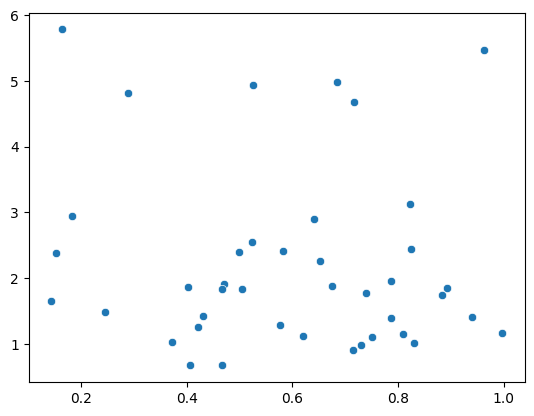

In [117]:
sns.scatterplot(x = ratio_in, y = ratio_compare)

In [118]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = x.reshape(-1, 61 * 30)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [119]:
valid_indices = spike_train['Neuron_1']
valid_indices = valid_indices[valid_indices < data.shape[0] - 31]
valid_indices = valid_indices[valid_indices > 30]

labels = label_array1_based_on_array2(valid_indices, spike_inf['time'], threshold=1)


In [120]:
sample_data = extract_windows(data.T, np.array(valid_indices), window_size=61)

In [121]:
device = 'cuda'
model = torch.load("/home/ubuntu/Documents/jct/project/code/Spike_Sorting/ANN_result/spike_detection.pth")
model = model.to(device)

In [122]:
correct = 0
total = 0
with torch.no_grad():
    batch_labels = torch.tensor(labels).float().unsqueeze(1)
    batch_data = torch.tensor(sample_data).to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_data)
    predicted = (outputs > 0.5).float()  
    total += batch_labels.size(0)
    correct += (predicted == batch_labels).sum().item()

In [123]:
predicted = np.stack(predicted.cpu().numpy(),axis=1)[0].astype(int)

In [124]:
valid_indices = valid_indices[predicted == 1]

In [125]:
spike_inf_temp = spike_inf[spike_inf['Neuron'] == 'Neuron_1']
count_array2_in_range_of_array1(valid_indices, spike_inf_temp['time'].values, threshold=15) / len(spike_inf_temp['time'])


0.4835459373604011

In [37]:
from probeinterface import  read_probeinterface
probe_30channel = read_probeinterface('/media/ubuntu/sda/data/probe.json')

In [38]:
probe_30channel = probe_30channel.to_dict()
channel_position = np.stack(probe_30channel['probes'][0]['contact_positions'], axis=1)
probe_x_range = (channel_position[0].min(), channel_position[0].max())
probe_y_range = (channel_position[1].min(), channel_position[1].max())

In [68]:
x_coords = np.arange(probe_x_range[0], probe_x_range[1] + 1, 50)  
y_coords = np.arange(probe_y_range[0], probe_y_range[1] + 1, 50) 
grid_x, grid_y = np.meshgrid(x_coords, y_coords)
grid_coords = np.stack([grid_x, grid_y], axis=-1)  
grid_coords = np.concatenate(grid_coords, axis=0)

In [42]:
waveform = neuron_inf['position_waveform'].values
waveform = np.stack(waveform, axis=0)

In [43]:
import numpy as np
from scipy.stats import pearsonr

def merge_similar_rows(matrix, threshold=0.95):
    """
    合并相似度高于阈值的行，并生成平均值行。

    参数:
    matrix : numpy.ndarray
        输入矩阵，形状为 (n, 61)。
    threshold : float
        相似度阈值，默认为 0.95。

    返回:
    merged_matrix : numpy.ndarray
        合并后的矩阵。
    """
    n = matrix.shape[0]
    to_merge = set()  # 用于记录需要合并的行索引
    merged_rows = []  # 存储合并后的行

    # 遍历矩阵的每一对行，计算相似度
    for i in range(n):
        if i in to_merge:  # 如果当前行已被标记为合并，跳过
            continue
        similar_rows = [i]  # 当前行的相似行索引
        for j in range(i + 1, n):
            if j in to_merge:  # 如果行 j 已被标记为合并，跳过
                continue
            # 计算皮尔逊相关系数
            corr, _ = pearsonr(matrix[i], matrix[j])
            if corr > threshold:
                similar_rows.append(j)
                to_merge.add(j)  # 标记行 j 为已合并

        # 计算相似行的平均值并添加到结果中
        merged_rows.append(np.mean(matrix[similar_rows], axis=0))

    # 转换为 NumPy 数组
    merged_matrix = np.array(merged_rows)
    return merged_matrix

In [44]:
waveform_merge = merge_similar_rows(waveform, threshold=0.95)

In [82]:
waveform_merge.shape

(7, 61)

<Axes: >

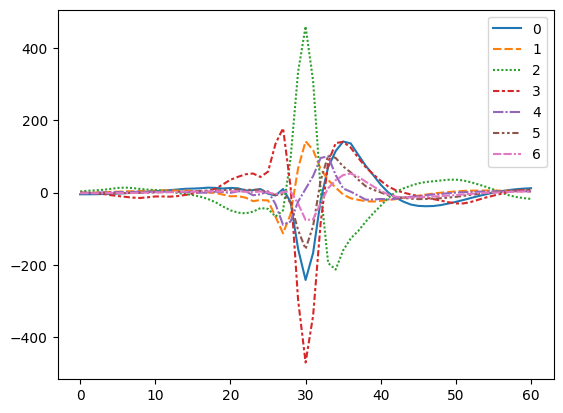

In [45]:
import seaborn as sns
sns.lineplot(waveform_merge.T)

In [46]:
std_channel = np.std(data, axis=0)
mean_channel = np.mean(data, axis=0)

In [75]:
corrds_df = pd.DataFrame()
corrds_df['x'] = grid_coords[:, 0]
corrds_df['y'] = grid_coords[:, 1]

In [160]:
channel_df = pd.DataFrame.from_dict(channel_position, orient='index', columns=['x', 'y'])
channel_df['channel_id'] = channel_df.index

def find_nearest_channels(row, channel_df, top_n=6):
    distances = np.sqrt((channel_df['x'] - row['x'])**2 + (channel_df['y'] - row['y'])**2)
    nearest_channels = channel_df.loc[distances.nsmallest(top_n).index, 'channel_id']
    return nearest_channels.tolist()

corrds_df['channel_id'] = corrds_df.apply(find_nearest_channels, axis=1, channel_df=channel_df)


In [161]:
def calculate_channel_waveform(waveform, position, channel_df, top_n=6, decay_factor=1.0):
    """
    计算每个波形在每个位置的最近通道的波形大小（考虑距离衰减）。
    对于不属于最近通道的通道，其波形值全部赋值为 0。
    """
    distances = np.sqrt((channel_df['x'] - position['x'])**2 + (channel_df['y'] - position['y'])**2)
    nearest_indices = distances.nsmallest(top_n).index
    nearest_channels = channel_df.loc[nearest_indices]
    nearest_distances = distances[nearest_indices]
    
    nearest_distances = np.maximum(nearest_distances, 1e-6)
    weights = 1 / (nearest_distances ** decay_factor)
    weights /= weights.sum()
    
    all_channel_waveform = np.zeros((len(channel_df), len(waveform)))
    
    
    for i, channel_id in enumerate(nearest_channels['channel_id']):
        all_channel_waveform[i, :] = weights[weights.index == channel_id].values * waveform  # 加权波形值
    
    return nearest_channels['channel_id'].tolist(), all_channel_waveform


In [ ]:
result = []
for i, waveform in enumerate(waveform_merge):
    for _, position in corrds_df.iterrows():
        channel_ids, channel_waveform = calculate_channel_waveform(waveform, position, channel_df)
        result.append({
            'waveform': i,
            'position': (position['x'], position['y']),
            'channel': channel_ids,
            'channel_waveform': channel_waveform
        })

result_df = pd.DataFrame(result)